In [ ]:
import os

from dotenv import load_dotenv

load_dotenv(os.path.join("..", ".env"), override=True)

%load_ext autoreload
%autoreload 2

## Context Offloading: Filesystem

Agent context windows can grow rapidly during complex tasks—the average Manus task uses approximately 50 tool calls, creating substantial context accumulation. A powerful technique for managing this growth is **context offloading** through filesystem operations. Rather than storing all tool call observations and intermediate results directly in the context window, agents can strategically save information to files and [fetch it as-needed](https://blog.langchain.com/context-engineering-for-agents/), maintaining focus while preserving access to critical information.

This approach has been successfully implemented by production systems like [Manus](https://manus.im/blog/Context-Engineering-for-AI-Agents-Lessons-from-Building-Manus) and [Hugging Face Open Deep Research](https://huggingface.co/blog/open-deep-research). Anthropic's [multi-agent research system](https://www.anthropic.com/engineering/multi-agent-research-system) provides another compelling example, where subagents store their work in external systems and pass lightweight references back to coordinators. This prevents the "game of telephone" effect—information degradation as it passes through multiple agents—while enabling fresh subagents to spawn with clean contexts and retrieve stored context like research plans from memory when needed.

By writing token-heavy context to files in sandboxed environments, agents can effectively manage memory while maintaining the ability to retrieve detailed information when necessary. This pattern is particularly valuable for structured outputs like code, reports, or data visualizations where specialized prompts produce better results than filtering through general coordinators, and for long-running research tasks where intermediate results need preservation without constant attention.

### Write File Tools

Our implementation uses a virtual filesystem approach that mocks the traditional filesystem within LangGraph state. The core insight is to use a simple dictionary where keys represent mock file paths and values contain the file content. This approach provides short-term, thread-wise persistence that's ideal for maintaining context within a single agent conversation, though it's not suited for information that needs to persist across different conversation threads. The file operations utilize LangGraph's `Command` type to update the agent state, enabling tools to modify the virtual filesystem and maintain proper state management throughout the agent's execution.

**TODO(Geoff)** We can explain the tools here in some more detail

In [2]:
from utils import show_prompt

from deep_agents_from_scratch.prompts import (
    LS_DESCRIPTION,
    READ_FILE_DESCRIPTION,
    WRITE_FILE_DESCRIPTION,
)

show_prompt(LS_DESCRIPTION)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  List all files in the virtual filesystem stored in agent state.                                                │
│                                                                                                                 │
│  Shows what files currently exist in agent memory. Use this to orient yourself before other file operations     │
│  and maintain awareness of your file organization.                                                              │
│                                                                                                                 │
│  No parameters required - simply call ls() to see all available files.                                          │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [3]:
show_prompt(READ_FILE_DESCRIPTION)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  Read content from a file in the virtual filesystem with optional pagination.                                   │
│                                                                                                                 │
│  This tool returns file content with line numbers (like `cat -n`) and supports reading large files in chunks    │
│  to avoid context overflow.                                                                                     │
│                                                                                                                 │
│  Parameters:                                                                                                    │
│  - file_path (required): Path to the file you want to read                                                      │
│  - offset (optional, default=0): Line number to start reading from                                              │
│  - limit (optional, default=2000): Maximum number of lines to read                                              │
│                                                                                                                 │
│  Essential before making any edits to understand existing content. Always read a file before editing it.        │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [4]:
show_prompt(WRITE_FILE_DESCRIPTION)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  Create a new file or completely overwrite an existing file in the virtual filesystem.                          │
│                                                                                                                 │
│  This tool creates new files or replaces entire file contents. Use for initial file creation or complete        │
│  rewrites. Files are stored persistently in agent state.                                                        │
│                                                                                                                 │
│  Parameters:                                                                                                    │
│  - file_path (required): Path where the file should be created/overwritten                                      │
│  - content (required): The complete content to write to the file                                                │
│                                                                                                                 │
│  Important: This replaces the entire file content. Use edit_file for partial modifications.                     │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [ ]:
from deep_agents_from_scratch.prompts import FILE_USAGE_INSTRUCTIONS

show_prompt(FILE_USAGE_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  You have access to a virtual file system to help you retain and save context.                                  │
│                                                                                                                 │
│  ## Workflow Process                                                                                            │
│  1. **Orient**: Use ls() to see existing files before starting work                                             │
│  2. **Save**: Use write_file() to store the user's request so that we can keep it for later                     │
│  3. **Research**: Proceed with research. The search tool will write files.                                      │
│  4. **Read**: Once you are satisfied with the collected sources, read the files and use them to answer the      │
│  user's question directly.                                                                                      │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

**TODO(Geoff)** Can see if we need any preamble text here. 

In [5]:
%%writefile ../src/deep_agents_from_scratch/file_tools.py

from typing import Annotated

from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command

from deep_agents_from_scratch.prompts import (
    LS_DESCRIPTION,
    READ_FILE_DESCRIPTION, 
    WRITE_FILE_DESCRIPTION,
)
from deep_agents_from_scratch.state import DeepAgentState

@tool(description=LS_DESCRIPTION)
def ls(state: Annotated[DeepAgentState, InjectedState]) -> list[str]:
    """List all files in the virtual filesystem."""
    
    return list(state.get("files", {}).keys())

@tool(description=READ_FILE_DESCRIPTION)
def read_file(
    file_path: str,
    state: Annotated[DeepAgentState, InjectedState],
    offset: int = 0,
    limit: int = 2000,
) -> str:

    files = state.get("files", {})
    if file_path not in files:
        return f"Error: File '{file_path}' not found"
    
    content = files[file_path]
    if not content:
        return "System reminder: File exists but has empty contents"
    
    lines = content.splitlines()
    start_idx = offset
    end_idx = min(start_idx + limit, len(lines))
    
    if start_idx >= len(lines):
        return f"Error: Line offset {offset} exceeds file length ({len(lines)} lines)"
    
    result_lines = []
    for i in range(start_idx, end_idx):
        line_content = lines[i][:2000]  # Truncate long lines
        result_lines.append(f"{i+1:6d}\t{line_content}")
    
    return "\n".join(result_lines)

@tool(description=WRITE_FILE_DESCRIPTION)
def write_file(
    file_path: str,
    content: str,
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
) -> Command:

    files = state.get("files", {})
    files[file_path] = content
    return Command(
        update={
            "files": files,
            "messages": [
                ToolMessage(f"Updated file {file_path}", tool_call_id=tool_call_id)
            ],
        }
    )

Overwriting ../src/deep_agents_from_scratch/file_tools.py


So, now we have a virtual filesystem and tools to work with it. Where else are files particularly useful? One obvious place discussed by Manus is offloading token-heavy tool observations! Let's build a search tool that offloads raw contents to files and returns only a summary to the agent. The summary will give the agent sufficient information to know what has been collected and steer further information gathering. However, it won't spam the agent with the raw content of the search results. 

In [ ]:
%%writefile ../src/deep_agents_from_scratch/research_tools.py

"""Research Tools.

This module provides search and content processing utilities for the research agent,
including web search capabilities and content summarization tools.
"""

from datetime import datetime

import httpx
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.tools import InjectedToolArg, InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command
from markdownify import markdownify
from pydantic import BaseModel, Field
from tavily import TavilyClient
from typing_extensions import Annotated, Literal

from deep_agents_from_scratch.prompts import SUMMARIZE_WEB_SEARCH
from deep_agents_from_scratch.state import DeepAgentState

# Summarization model 
summarization_model = init_chat_model(model="openai:gpt-4o-mini")
tavily_client = TavilyClient()

class Summary(BaseModel):
    """Schema for webpage content summarization."""
    filename: str = Field(description="Name of the file to store.")
    summary: str = Field(description="Key learnings from the webpage.")

def get_today_str() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%a %b %-d, %Y")

def run_tavily_search(
    search_query: str, 
    max_results: int = 1, 
    topic: Literal["general", "news", "finance"] = "general", 
    include_raw_content: bool = True, 
) -> dict:
    """Perform search using Tavily API for a single query.

    Args:
        search_query: Search query to execute
        max_results: Maximum number of results per query
        topic: Topic filter for search results
        include_raw_content: Whether to include raw webpage content

    Returns:
        Search results dictionary
    """
    result = tavily_client.search(
        search_query,
        max_results=max_results,
        include_raw_content=include_raw_content,
        topic=topic
    )

    return result

def summarize_webpage_content(webpage_content: str) -> Summary:
    """Summarize webpage content using the configured summarization model.
    
    Args:
        webpage_content: Raw webpage content to summarize
        
    Returns:
        Summary object with filename and summary
    """
    try:
        # Set up structured output model for summarization
        structured_model = summarization_model.with_structured_output(Summary)
        
        # Generate summary
        summary_and_filename = structured_model.invoke([
            HumanMessage(content=SUMMARIZE_WEB_SEARCH.format(
                webpage_content=webpage_content, 
                date=get_today_str()
            ))
        ])
        
        return summary_and_filename
        
    except Exception:
        # Return a basic summary object on failure
        return Summary(
            filename="search_result.md",
            summary=webpage_content[:1000] + "..." if len(webpage_content) > 1000 else webpage_content
        )

def process_search_results(results: dict) -> list[dict]:
    """Process search results by summarizing content where available.
    
    Args:
        results: Tavily search results dictionary
        
    Returns:
        List of processed results with summaries
    """
    processed_results = []

    # Create a client for HTTP requests
    HTTPX_CLIENT = httpx.Client()
    
    for result in results.get('results', []):
        
        # Get url 
        url = result['url']
        
        # Read url
        response = HTTPX_CLIENT.get(url)
        response.raise_for_status()

        if response.status_code == 200:
            # Convert HTML to markdown
            raw_content = markdownify(response.text)
            summary_obj = summarize_webpage_content(raw_content)
        else:
            # Use Tavily's generated summary
            raw_content = result.get('raw_content', '')
            summary_obj = Summary(
                filename=None,
                summary=result.get('content', 'Error reading URL; try another search.')
            )
        
        processed_results.append({
            'url': result['url'],
            'title': result['title'],
            'summary': summary_obj.summary,
            'filename': summary_obj.filename,
            'raw_content': raw_content,
        })
    
    return processed_results

@tool(parse_docstring=True)
def tavily_search(
    query: str,
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
    max_results: Annotated[int, InjectedToolArg] = 1,
    topic: Annotated[Literal["general", "news", "finance"], InjectedToolArg] = "general",
) -> Command:
    """Search web and save detailed results to files while returning minimal context.

    Performs web search and saves full content to files for context offloading.
    Returns only essential information to help the agent decide on next steps.

    Args:
        query: Search query to execute
        state: Injected agent state for file storage
        tool_call_id: Injected tool call identifier
        max_results: Maximum number of results to return (default: 1)
        topic: Topic filter - 'general', 'news', or 'finance' (default: 'general')

    Returns:
        Command that saves full results to files and provides minimal summary
    """
    # Execute search
    search_results = run_tavily_search(
        query,
        max_results=max_results,
        topic=topic,
        include_raw_content=True,
    ) 

    # Process and summarize results
    processed_results = process_search_results(search_results)
    
    # Save each result to a file and prepare summary
    files = state.get("files", {})
    saved_files = []
    summaries = []
    
    for i, result in enumerate(processed_results):
        # Use the AI-generated filename from summarization
        filename = result['filename']
        
        # Create file content with full details
        file_content = f"""# Search Result: {result['title']}

**URL:** {result['url']}
**Query:** {query}
**Date:** {get_today_str()}

## Summary
{result['summary']}

## Raw Content
{result['raw_content'] if result['raw_content'] else 'No raw content available'}
"""
        
        files[filename] = file_content
        saved_files.append(filename)
        # Use only first 80 chars for very concise context
        summaries.append(f"- {filename}: {result['summary']}...")
    
    # Create minimal summary for tool message - focus on what was collected
    summary_text = f"""🔍 Found {len(processed_results)} result(s) for '{query}':

{chr(10).join(summaries)}

Files: {', '.join(saved_files)}
💡 Use read_file() to access full details when needed."""

    return Command(
        update={
            "files": files,
            "messages": [
                ToolMessage(summary_text, tool_call_id=tool_call_id)
            ],
        }
    )

@tool(parse_docstring=True)
def think_tool(reflection: str) -> str:
    """Tool for strategic reflection on research progress and decision-making.

    Use this tool after each search to analyze results and plan next steps systematically.
    This creates a deliberate pause in the research workflow for quality decision-making.

    When to use:
    - After receiving search results: What key information did I find?
    - Before deciding next steps: Do I have enough to answer comprehensively?
    - When assessing research gaps: What specific information am I still missing?
    - Before concluding research: Can I provide a complete answer now?

    Reflection should address:
    1. Analysis of current findings - What concrete information have I gathered?
    2. Gap assessment - What crucial information is still missing?
    3. Quality evaluation - Do I have sufficient evidence/examples for a good answer?
    4. Strategic decision - Should I continue searching or provide my answer?

    Args:
        reflection: Your detailed reflection on research progress, findings, gaps, and next steps

    Returns:
        Confirmation that reflection was recorded for decision-making
    """
    return f"Reflection recorded: {reflection}"

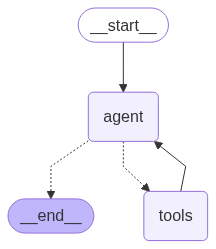

In [7]:
from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import create_react_agent
from utils import format_messages

from deep_agents_from_scratch.file_tools import ls, read_file, write_file
from deep_agents_from_scratch.prompts import (
    FILE_USAGE_INSTRUCTIONS,
    RESEARCHER_INSTRUCTIONS,
)
from deep_agents_from_scratch.research_tools import tavily_search, think_tool
from deep_agents_from_scratch.state import DeepAgentState

# Create agent using create_react_agent directly
model = init_chat_model(model="anthropic:claude-sonnet-4-20250514", temperature=0.0)
tools = [ls, read_file, write_file, tavily_search, think_tool]

# Create agent with system prompt
agent = create_react_agent(model, tools, prompt=RESEARCHER_INSTRUCTIONS+"\n\n"+FILE_USAGE_INSTRUCTIONS, state_schema=DeepAgentState)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

Start the graph with no `files` in state and an user research request. 

In [ ]:

result = agent.invoke({
    "messages": [{"role": "user", "content": "Give me an overview of Model Context Protocol (MCP)."}],
    "files": {}
})
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an overview of Model Context Protocol (MCP).                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you research the Model Context Protocol (MCP). Let me start by checking what files are available and  │
│ then conducting a comprehensive search.                                                                         │
│                                                                                                                 │
│ 🔧 Tool Call: ls                                                                                                │
│    Args: {}                                                                                                     │
│    ID: toolu_01SJ8s8jMAdwndpxvjUtmqh3                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "research_request.txt",                                                                          │
│   "content": "User Request: Give me an overview of Model Context Protocol (MCP)\n\nResearch Goal: Provide a     │
│ comprehensive overview of MCP including:\n- What it is and its purpose\n- Key features and capabilities\n- How  │
│ it works\n- Use cases and applications\n- Current status and adoption"                                          │
│ }                                                                                                               │
│    ID: toolu_01CRp4dBBx23uHou9FCbzaA4                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file research_request.txt                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Now let me search for information about the Model Context Protocol.                                             │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "Model Context Protocol MCP overview what is purpose features"                                       │
│ }                                                                                                               │
│    ID: toolu_01SuDvwQ1FetCvrhv7D5F6de                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 🔍 Found 1 result(s) for 'Model Context Protocol MCP overview what is purpose features':                        │
│                                                                                                                 │
│ - mcp_protocol_overview.md: The Model Context Protocol (MCP) is an open standard developed by Anthropic to      │
│ facilitate integration between AI applications and external systems. It simplifies connections through a        │
│ client-server architecture and establishes guidelines for tools, resources, and prompts for AI models. Key      │
│ findings include MCP's ability to standardize AI interactions and its backing by a comprehensive specification  │
│ and growing ecosystem, making it an essential tool for modern AI development....                                │
│                                                                                                                 │
│ Files: mcp_protocol_overview.md                                                                                 │
│ 💡 Use read_file() to access full details when needed.                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "I found initial information about MCP from the search. The results indicate that MCP is an     │
│ open standard by Anthropic for AI application integration with external systems, using a client-server          │
│ architecture. However, I need more detailed information about:\n\n1. Technical specifications and how it        │
│ works\n2. Specific use cases and examples\n3. Current adoption status\n4. Implementation details\n\nLet me      │
│ conduct another search to get more comprehensive technical details and examples."                               │
│ }                                                                                                               │
│    ID: toolu_015KVpLFyEcwDNnqz9xduZ8u                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: I found initial information about MCP from the search. The results indicate that MCP is an │
│ open standard by Anthropic for AI application integration with external systems, using a client-server          │
│ architecture. However, I need more detailed information about:                                                  │
│                                                                                                                 │
│ 1. Technical specifications and how it works                                                                    │
│ 2. Specific use cases and examples                                                                              │
│ 3. Current adoption status                                                                                      │
│ 4. Implementation details                                                                                       │
│                                                                                                                 │
│ Let me conduct another search to get more comprehensive technical details and examples.                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "Model Context Protocol MCP Anthropic technical specification implementation examples"               │
│ }                                                                                                               │
│    ID: toolu_01MsoryoqDr5g4TDQf5NwhZG                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 🔍 Found 1 result(s) for 'Model Context Protocol MCP Anthropic technical specification implementation           │
│ examples':                                                                                                      │
│                                                                                                                 │
│ - mcp_protocol_overview.md: The Model Context Protocol (MCP) is an open protocol designed for integrating       │
│ language model applications with external data and tools. It enables seamless communication through JSON-RPC    │
│ messages between hosts (LLM applications), clients (connectors), and servers (context services). Key findings   │
│ include principles emphasizing user consent and data privacy, alongside features such as contextual resource    │
│ sharing and tools for AI systems....                                                                            │
│                                                                                                                 │
│ Files: mcp_protocol_overview.md                                                                                 │
│ 💡 Use read_file() to access full details when needed.                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "Good, I'm getting more technical details about MCP. The search revealed that MCP uses JSON-RPC │
│ messages for communication between hosts (LLM applications), clients (connectors), and servers (context         │
│ services). It also mentions principles around user consent and data privacy. \n\nHowever, I should search for   │
│ more specific information about:\n1. Real-world use cases and applications\n2. Current ecosystem and tools      │
│ available\n3. How developers can implement it\n\nLet me do one more targeted search to gather comprehensive     │
│ information about the ecosystem and practical applications."                                                    │
│ }                                                                                                               │
│    ID: toolu_01FMkou9ASdaVQfXhfCtuHm7                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: Good, I'm getting more technical details about MCP. The search revealed that MCP uses      │
│ JSON-RPC messages for communication between hosts (LLM applications), clients (connectors), and servers         │
│ (context services). It also mentions principles around user consent and data privacy.                           │
│                                                                                                                 │
│ However, I should search for more specific information about:                                                   │
│ 1. Real-world use cases and applications                                                                        │
│ 2. Current ecosystem and tools available                                                                        │
│ 3. How developers can implement it                                                                              │
│                                                                                                                 │
│ Let me do one more targeted search to gather comprehensive information about the ecosystem and practical        │
│ applications.                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "\"Model Context Protocol\" MCP ecosystem tools servers applications Claude desktop"                 │
│ }                                                                                                               │
│    ID: toolu_01Fbh78V665KdUaFJjnoBiWG                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 🔍 Found 1 result(s) for '"Model Context Protocol" MCP ecosystem tools servers applications Claude desktop':    │
│                                                                                                                 │
│ - model_context_protocol_overview.md: The Model Context Protocol (MCP) is an open-source standard developed by  │
│ Anthropic for connecting AI assistants to various data sources, enhancing their ability to produce relevant     │
│ responses. Key components include the MCP specification, SDKs, and local server support for AI applications. It │
│ eliminates the need for custom integrations for each data source, facilitating a streamlined connection between │
│ AI systems and essential datasets, thus advancing context-aware AI development....                              │
│                                                                                                                 │
│ Files: model_context_protocol_overview.md                                                                       │
│ 💡 Use read_file() to access full details when needed.                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "Excellent! Now I have comprehensive information about MCP from multiple searches. The key      │
│ findings include:\n\n1. MCP is an open-source standard by Anthropic\n2. It connects AI assistants to various    │
│ data sources\n3. Uses JSON-RPC for communication between hosts, clients, and servers\n4. Eliminates need for    │
│ custom integrations\n5. Has SDKs and local server support\n6. Focuses on context-aware AI development\n7.       │
│ Emphasizes user consent and data privacy\n\nI believe I have enough information to provide a comprehensive      │
│ overview. Let me read the detailed files to compile a complete answer for the user."                            │
│ }                                                                                                               │
│    ID: toolu_01JKhfytRJdfcnCY2ioTB89U                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: Excellent! Now I have comprehensive information about MCP from multiple searches. The key  │
│ findings include:                                                                                               │
│                                                                                                                 │
│ 1. MCP is an open-source standard by Anthropic                                                                  │
│ 2. It connects AI assistants to various data sources                                                            │
│ 3. Uses JSON-RPC for communication between hosts, clients, and servers                                          │
│ 4. Eliminates need for custom integrations                                                                      │
│ 5. Has SDKs and local server support                                                                            │
│ 6. Focuses on context-aware AI development                                                                      │
│ 7. Emphasizes user consent and data privacy                                                                     │
│                                                                                                                 │
│ I believe I have enough information to provide a comprehensive overview. Let me read the detailed files to      │
│ compile a complete answer for the user.                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "mcp_protocol_overview.md"                                                                       │
│ }                                                                                                               │
│    ID: toolu_01X6DpbUH69NuHqD2mbao43F                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│      1  # Search Result: Specification - Model Context Protocol                                                 │
│      2                                                                                                          │
│      3  **URL:** https://modelcontextprotocol.io/specification/2025-06-18                                       │
│      4  **Query:** Model Context Protocol MCP Anthropic technical specification implementation examples         │
│      5  **Date:** Thu Aug 14, 2025                                                                              │
│      6                                                                                                          │
│      7  ## Summary                                                                                              │
│      8  The Model Context Protocol (MCP) is an open protocol designed for integrating language model            │
│ applications with external data and tools. It enables seamless communication through JSON-RPC messages between  │
│ hosts (LLM applications), clients (connectors), and servers (context services). Key findings include principles │
│ emphasizing user consent and data privacy, alongside features such as contextual resource sharing and tools for │
│ AI systems.                                                                                                     │
│      9                                                                                                          │
│     10  ## Raw Content                                                                                          │
│     11  Specification - Model Context Protocol                                                                  │
│     12                                                                                                          │
│     13  [Model Context Protocol home                                                                            │
│ page!(https://mintlify.s3.us-west-1.amazonaws.com/mcp/logo/light.svg)!(https://mintlify.s3.us-west-1.amazonaws. │
│ com/mcp/logo/dark.svg)](/)                                                                                      │
│     14                                                                                                          │
│     15  Version 2025-06-18 (latest)                                                                             │
│     16                                                                                                          │
│     17  Search...                                                                                               │
│     18                                                                                                          │
│     19  ⌘K                                                                                                      │
│     20                                                                                                          │
│     21  * [Blog](https://blog.modelcontextprotocol.io)                                                          │
│     22  * [GitHub](https://github.com/modelcontextprotocol)                                                     │
│     23                                                                                                          │
│     24  Search...                                                                                               │
│     25                                                                                                          │
│     26  Navigation                                                                                              │
│     27                                                                                                          │
│     28  Specification                                  

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "model_context_protocol_overview.md"                                                             │
│ }                                                                                                               │
│    ID: toolu_01GxRCw6Er5Rqs1EzPS5bSrA                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│      1  # Search Result: Introducing the Model Context Protocol - Anthropic                                     │
│      2                                                                                                          │
│      3  **URL:** https://www.anthropic.com/news/model-context-protocol                                          │
│      4  **Query:** "Model Context Protocol" MCP ecosystem tools servers applications Claude desktop             │
│      5  **Date:** Thu Aug 14, 2025                                                                              │
│      6                                                                                                          │
│      7  ## Summary                                                                                              │
│      8  The Model Context Protocol (MCP) is an open-source standard developed by Anthropic for connecting AI    │
│ assistants to various data sources, enhancing their ability to produce relevant responses. Key components       │
│ include the MCP specification, SDKs, and local server support for AI applications. It eliminates the need for   │
│ custom integrations for each data source, facilitating a streamlined connection between AI systems and          │
│ essential datasets, thus advancing context-aware AI development.                                                │
│      9                                                                                                          │
│     10  ## Raw Content                                                                                          │
│     11  Introducing the Model Context Protocol \ Anthropic                                                      │
│     12                                                                                                          │
│     13  [Skip to main content](#main-content)[Skip to footer](#footer)                                          │
│     14                                                                                                          │
│     15  * Claude                                                                                                │
│     16  * API                                                                                                   │
│     17  * Solutions                                                                                             │
│     18  * Research                                                                                              │
│     19  * Commitments                                                                                           │
│     20  * Learn                                                                                                 │
│     21  [News](/news)[Try Claude](https://claude.ai/)                                                           │
│     22                                                                                                          │
│     23  Announcements                                                                                           │
│     24                                                                                                          │
│     25  Introducing the Model Context Protocol                                                                  │
│     26  ======================================                                                                  │
│     27                                                                                                          │
│     28  Nov 25, 2024●3 min read                                                                                 │
│     29                                                                                                          │
│     30  ![An abstract illustration of critical context 

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Based on my research, I can now provide you with a comprehensive overview of the Model Context Protocol (MCP).  │
│                                                                                                                 │
│ # Model Context Protocol (MCP) Overview                                                                         │
│                                                                                                                 │
│ ## What is MCP?                                                                                                 │
│                                                                                                                 │
│ The Model Context Protocol (MCP) is an **open-source standard** developed by Anthropic that enables seamless    │
│ integration between AI assistants and external data sources, tools, and systems. Released in November 2024, MCP │
│ addresses a critical challenge in AI development: connecting sophisticated language models to the data they     │
│ need while maintaining security and user control.                                                               │
│                                                                                                                 │
│ ## Purpose and Problem It Solves                                                                                │
│                                                                                                                 │
│ MCP was created to solve the **data isolation problem** that limits AI assistants. Even the most advanced       │
│ models are often "trapped behind information silos and legacy systems," requiring custom implementations for    │
│ each new data source. This fragmented approach makes it difficult to build truly connected, scalable AI         │
│ systems.                                                                                                        │
│                                                                                                                 │
│ MCP provides a **universal, open standard** that replaces these fragmented integrations with a single protocol, │
│ making it simpler and more reliable to give AI systems access to the data they need.                            │
│                                                                                                                 │
│ ## How It Works                                                                                                 │
│                                                                                                                 │
│ ### Architecture                                                                                                │
│ MCP uses a **client-server architecture** with **JSON-RPC 2.0** messages for communication between three key    │
│ components:                                                                                                     │
│                                                                                                                 │
│ - **Hosts**: LLM applications that initiate connections                                                         │
│ - **Clients**: Connectors within the host application                                                           │
│ - **Servers**: Services that provide context and capabilities                                                   │
│                                                                                                                 │
│ ### Key Features                                                                                                │
│                                                                                                                 │
│ **Server Features** (what servers can offer to clients)

We can see the file saved in our mock file system. 

In [9]:
result['files']

{'research_request.txt': 'User Request: Give me an overview of Model Context Protocol (MCP)\n\nResearch Goal: Provide a comprehensive overview of MCP including:\n- What it is and its purpose\n- Key features and capabilities\n- How it works\n- Use cases and applications\n- Current status and adoption',
 'mcp_protocol_overview.md': '# Search Result: Specification - Model Context Protocol\n\n**URL:** https://modelcontextprotocol.io/specification/2025-06-18\n**Query:** Model Context Protocol MCP Anthropic technical specification implementation examples\n**Date:** Thu Aug 14, 2025\n\n## Summary\nThe Model Context Protocol (MCP) is an open protocol designed for integrating language model applications with external data and tools. It enables seamless communication through JSON-RPC messages between hosts (LLM applications), clients (connectors), and servers (context services). Key findings include principles emphasizing user consent and data privacy, alongside features such as contextual resou

Trace: 

https://smith.langchain.com/public/12a5f934-72d8-41b8-9e9a-72df4816834a/r